In [1]:
import collections
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import warnings
from pypfopt import EfficientFrontier
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

In [2]:
class HRPRegOpt():
    def __init__(self, returns=None, cov_matrix=None):
        if returns is None and cov_matrix is None:
            raise ValueError('Returns or cov_matrix should be provided')
        
        self.returns = returns
        if cov_matrix is None:
            self.cov_matrix = self.returns.cov()
        else:
            self.cov_matrix = cov_matrix
        self.clusters = None
        self.tickers = list(returns.columns)
        self.num_assets = len(self.tickers)
        
    
    @staticmethod
    def _get_cluster_var(cov, cluster_items):
        cov_slice = cov.loc[cluster_items, cluster_items]
        weights = 1 / np.diag(cov_slice)
        weights /= weights.sum()
        return np.linalg.multi_dot((weights, cov_slice, weights))

    
    @staticmethod
    def _raw_hrp_allocation(cov, root_node):
        """
        Given the clusters, compute the portfolio that minimises risk by
        recursively traversing the hierarchical tree from the top
        """
        ordered_tickers = cov.index[root_node.pre_order()].tolist()
        
        w = pd.Series(1, index=ordered_tickers)
        cluster_items = [ordered_tickers]  # initialize all items in one cluster

        while len(cluster_items) > 0:
            cluster_items = [
                i[j:k]
                for i in cluster_items
                for j, k in ((0, len(i) // 2), (len(i) // 2, len(i)))
                if len(i) > 1
            ]  # bi-section
            # For each pair, optimize locally
            for i in range(0, len(cluster_items), 2):
                first_cluster = cluster_items[i]
                second_cluster = cluster_items[i + 1]
                # Form the inverse variance portfolio for this pair
                first_variance = HRPRegOpt._get_cluster_var(cov, first_cluster)
                second_variance = HRPRegOpt._get_cluster_var(cov, second_cluster)
                alpha = 1 - first_variance / (first_variance + second_variance)
                w[first_cluster] *= alpha  # weight 1
                w[second_cluster] *= 1 - alpha  # weight 2
        return w

    
    @staticmethod
    def _hrp_allocation(cov, root_node):
        def _recursive_hrp_allocation(cov, root_node):
            if root_node.is_leaf():
                return
            
            first_node = root_node.get_left()
            second_node = root_node.get_right()
            first_cluster = cov.index[first_node.pre_order()].tolist()
            second_cluster = cov.index[second_node.pre_order()].tolist()
            # Form the inverse variance portfolio for this pair
            first_variance = HRPRegOpt._get_cluster_var(cov, first_cluster)
            second_variance = HRPRegOpt._get_cluster_var(cov, second_cluster)
            
            alpha = 1 - first_variance / (first_variance + second_variance)
            
            w[first_cluster] *= alpha
            w[second_cluster] *= 1 - alpha
            _recursive_hrp_allocation(cov, first_node)
            _recursive_hrp_allocation(cov, second_node)
            
        ordered_tickers = cov.index[root_node.pre_order()].tolist()
        
        w = pd.Series(1, index=ordered_tickers)
        _recursive_hrp_allocation(cov, root_node)
        return w

    
    @staticmethod
    def _get_reg_clusters(cov, root_node, lambda_reg=0.0):
        def _recursive_clustering(cov, root_node):
            if root_node.is_leaf():
                reg_clusters.append(root_node)
                return
            
            cluster = cov.index[root_node.pre_order()].tolist()
            cluster_variance = hrp_opt._get_cluster_var(cov, cluster)
        
            first_node = root_node.get_left()
            second_node = root_node.get_right()
            first_cluster = cov.index[first_node.pre_order()].tolist()
            second_cluster = cov.index[second_node.pre_order()].tolist()
            
            first_variance = hrp_opt._get_cluster_var(cov, first_cluster)
            second_variance = hrp_opt._get_cluster_var(cov, second_cluster)
            alpha = 1 - first_variance / (first_variance + second_variance)            
            subclusters_variance = alpha ** 2 * first_variance + (1 - alpha) ** 2 * second_variance
        
            if subclusters_variance / cluster_variance >= lambda_reg:
                _recursive_clustering(cov, first_node)
                _recursive_clustering(cov, second_node)
            else:
                reg_clusters.append(root_node)
                return
        
        reg_clusters = []
        ordered_tickers = cov.index[root_node.pre_order()].tolist()
        _recursive_clustering(cov, root_node)
        return reg_clusters
    
    
    @staticmethod
    def _cov_to_corr(cov_matrix):
        """
        Convert a covariance matrix to a correlation matrix
        """
        if not isinstance(cov_matrix, pd.DataFrame):
            warnings.warn('Covariance matrix is not a dataframe', RuntimeWarning)
            cov_matrix = pd.DataFrame(cov_matrix)
            
        Dinv = np.diag(1 / np.sqrt(np.diag(cov_matrix)))
        corr = np.dot(Dinv, np.dot(cov_matrix, Dinv))
        return pd.DataFrame(corr, index=cov_matrix.index, columns=cov_matrix.index)
    
    
    def plot_dendrogram(self, show_tickers=True):
        """
        Plot the clusters in the form of a dendrogram
        """
        ax = plt.gca()
        fig = plt.gcf()
        
        if self.clusters is None:
            warnings.warn(
                'Should do optimisation first',
                RuntimeWarning,
            )
            self.optimize()
        
        if show_tickers:
            sch.dendrogram(self.clusters, labels=self.tickers, ax=ax)
            ax.tick_params(axis='x', rotation=90)
            plt.tight_layout()
        else:
            sch.dendrogram(self.clusters)
        fig.set_size_inches(8, 5)
        fig.savefig('hrp_dendrogram.png', bbox_inches='tight', dpi=100)
        fig.savefig('hrp_dendrogram.jpg', bbox_inches='tight', dpi=100)
    
    
    @staticmethod
    def _get_within_cluster_weights(cov, reg_clusters, hrp_opt_method):
        weights = {}
        for node in reg_clusters:
            cluster_names = cov.columns[node.pre_order()].tolist()
            if hrp_opt_method == 'raw':
                weights[cluster_names[0] + ': ' + str(len(cluster_names))] = HRPRegOpt._raw_hrp_allocation(cov, node)
            if hrp_opt_method == 'exact':
                weights[cluster_names[0] + ': ' + str(len(cluster_names))] = HRPRegOpt._hrp_allocation(cov, node)          
        return weights
    
    
    @staticmethod
    def _get_cluster_returns(returns, within_cluster_weights):
        cluster_returns = {}
        for c_name in within_cluster_weights.keys():
            cluster_returns[c_name] = (returns[within_cluster_weights[c_name].index] * within_cluster_weights[c_name].values).sum(axis=1)
        return pd.DataFrame.from_dict(cluster_returns)
    
    
    @staticmethod
    def _get_global_weights(within_cluster_weights, global_cluster_weights):
        final_asset_weights = {}
        for c in global_cluster_weights:
            for i in within_cluster_weights[c].keys():
                final_asset_weights[i] = global_cluster_weights[c] * within_cluster_weights[c][i]
        return final_asset_weights

        
    def optimize(self, global_opt_params=('min_volatility', None), frequency=252, risk_free_rate=0.0, linkage_method='single', hrp_opt_method='exact', lambda_reg=0.5):
        """
        :param linkage_method: which scipy linkage method to use
        :return: weights for the HRP portfolio
        """
        if linkage_method not in sch._LINKAGE_METHODS:
            raise ValueError('Linkage method is not recognised')
            
        if self.returns is None:
            cov = self.cov_matrix
            corr = self._cov_to_corr(self.cov_matrix)
        else:
            corr, cov = self.returns.corr(), self.returns.cov()
            
        # clip to avoid floating point issues    
        matrix = np.sqrt(np.clip((1.0 - corr) / 2.0, a_min=0.0, a_max=1.0))
        dist = ssd.squareform(matrix, checks=False)
        
        self.clusters = sch.linkage(dist, linkage_method)
        root_node = sch.to_tree(self.clusters, rd=False)
        
        reg_clusters = self._get_reg_clusters(cov, root_node, lambda_reg)        
        within_cluster_weights = self._get_within_cluster_weights(cov, reg_clusters, hrp_opt_method)
        cluster_returns = self._get_cluster_returns(self.returns, within_cluster_weights)
        
        global_opt_method = global_opt_params[0]
        global_opt_constraint = global_opt_params[1]
        
        cluster_mu = cluster_returns.mean() * frequency
        cluster_S =  cluster_returns.cov() * frequency
        cluster_ef = EfficientFrontier(cluster_mu, cluster_S)
        
        if global_opt_method == 'min_volatility':
            cluster_ef.min_volatility()
        if global_opt_method == 'efficient_risk':
            target_volatility = global_opt_constraint
            cluster_ef.efficient_risk(target_volatility=target_volatility)
        if global_opt_method == 'max_sharpe':
            cluster_ef.max_sharpe(risk_free_rate=risk_free_rate)
            
        # cluster_ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
        global_cluster_weights = cluster_ef.clean_weights()
        # print(global_cluster_weights)
        
        final_asset_weights = self._get_global_weights(within_cluster_weights, global_cluster_weights)
        final_asset_weights = pd.DataFrame(final_asset_weights, index=['weight'])
        # print(final_asset_weights)
        # print(global_cluster_weights)
        
        return final_asset_weights[self.returns.columns]

In [3]:
def portfolio_performance(returns, weights, frequency=252, risk_free_rate=0.0):
    annual_return = 100 * frequency * pd.DataFrame((returns * weights.values).sum(axis=1).values).mean()[0]
    annual_volatility = 100 * np.sqrt(frequency * pd.DataFrame((returns * weights.values).sum(axis=1).values).cov())[0][0]
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    metrics = {'Annual return': annual_return,
               'Annual volatility': annual_volatility,
               'Sharpe ratio': sharpe_ratio}
    return metrics

In [4]:
def hyper_param_opt(hyper_param_opt_init_period,
                    hyper_param_opt_eval_period,
                    returns,
                    global_opt_params=('efficient_risk', 1.0),
                    hrp_opt_method='exact',
                    linkage_method='single',
                    risk_free_rate=0.0,
                    frequency=252,
                    num_opt_points=25):
    metrics = {}
    for lambda_reg in np.linspace(0, 1, num_opt_points):
        init_returns = returns.iloc[hyper_param_opt_init_period]
        hrp_opt = HRPRegOpt(init_returns)
        init_weights = hrp_opt.optimize(global_opt_params=global_opt_params,
                                        hrp_opt_method=hrp_opt_method,
                                        frequency=frequency,
                                        risk_free_rate=risk_free_rate,
                                        lambda_reg=lambda_reg,
                                        linkage_method=linkage_method)
        eval_returns = returns.iloc[hyper_param_opt_eval_period]
        metrics[lambda_reg] = portfolio_performance(eval_returns,
                                                    init_weights,
                                                    frequency=frequency,
                                                    risk_free_rate=risk_free_rate)
    return metrics

In [12]:
df = pd.read_csv("resources/stock_prices.csv", parse_dates=True, index_col="date")
returns = df.pct_change().dropna()
hrp_opt = HRPRegOpt(returns)

<ipython-input-9-ff0eb82d0424>:138: RuntimeWarning: Should do optimisation first
  warnings.warn(


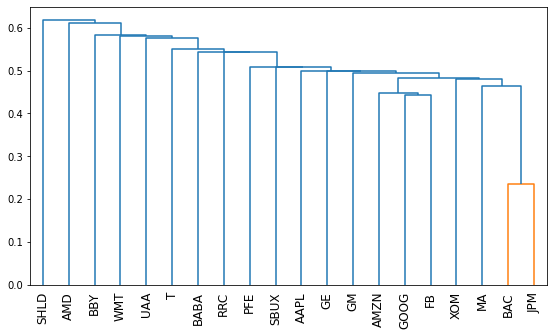

In [13]:
hrp_opt.plot_dendrogram(show_tickers=True)

In [14]:
num_days = returns.shape[0]
hyper_param_opt_init_period = list(range(0, num_days // 2))
hyper_param_opt_eval_period = list(range(num_days // 2, num_days))

In [15]:
hyper_param_opt(hyper_param_opt_init_period, hyper_param_opt_eval_period, returns, linkage_method='single', global_opt_params=('efficient_risk', 0.2))

{0.0: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.041666666666666664: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.08333333333333333: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.125: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.16666666666666666: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.20833333333333331: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.25: {'Annual return': 20.224854811106937,
  'Annual volatility': 14.448568831321937,
  'Sharpe ratio': 1.399782569970739},
 0.29166666666666663: {'Annual return': 20.22485481110693

# Experiments with Russian stocks

In [16]:
df = pd.read_csv('resources/RTS_prices.csv', parse_dates=True, index_col='date')
returns = df.pct_change().dropna()
returns

,GAZP RX,LKOH RX,NVTK RX,ROSN RX,SNGS RX,TATN RX,TRNFP RX,ALRS RX,CHMF RX,GMKN RX,...,RTKM RX,VEON US,FEES RX,HYDR RX,IRAO RX,UPRO RX,ENRU RX,LSRG RX,PIKK RX,ETLN LI
date,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.013869,0.018065,0.000000,0.018788,-0.016531,0.029043,0.004113,0.009676,0.001522,-0.012441,...,0.006369,-0.012740,0.057464,0.005539,0.052536,0.017241,0.019405,0.001506,0.003640,0.024785
2015-01-04,0.029518,0.018484,0.042361,0.036486,0.025356,0.045645,0.013735,0.013889,-0.020517,0.013463,...,0.012658,-0.009830,0.032180,0.023742,0.018274,0.000000,0.017766,-0.018045,0.001036,0.024953
2015-02-04,0.006294,0.009256,0.037531,0.004592,0.028063,0.004665,0.053799,0.008356,-0.002327,-0.042604,...,0.005250,0.004328,0.017647,0.001855,-0.014821,-0.020339,0.038653,0.006126,-0.037267,0.015490
2015-03-04,0.000278,0.015932,0.019692,0.004380,-0.008378,-0.008292,-0.029549,-0.016302,-0.003033,0.014569,...,0.003482,0.000000,-0.002890,0.031111,0.001450,0.008997,-0.016807,-0.010654,0.037634,0.000000
2015-06-04,0.012227,-0.000531,0.003359,0.009291,0.017443,0.028261,-0.011389,0.005662,-0.004446,-0.003614,...,0.030855,0.048774,0.033913,0.020295,0.063077,0.039095,0.012210,0.006154,-0.003109,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-12,-0.031858,-0.007873,-0.031742,-0.009694,0.011500,-0.010690,0.006646,-0.016890,-0.006547,-0.007484,...,0.005135,-0.028112,-0.003780,-0.012863,-0.021911,-0.001070,-0.016092,-0.010791,0.001344,0.036496
2021-07-12,0.021162,0.016930,0.036790,0.029802,0.022481,0.021407,0.003475,0.029544,0.031399,0.006989,...,0.023221,0.037530,-0.020394,0.028211,0.019053,0.007857,0.015888,0.020420,0.000089,-0.002596
2021-08-12,-0.016025,-0.031141,-0.014287,-0.034202,-0.028304,-0.017964,-0.015235,-0.017935,-0.009647,-0.000639,...,0.008851,-0.024289,0.007988,-0.020120,-0.009632,-0.020198,0.000230,-0.013158,0.028096,-0.007844


In [17]:
252 * 100 * returns.mean()

GAZP RX     16.415464
LKOH RX     17.601310
NVTK RX     24.148566
ROSN RX     16.428159
SNGS RX      5.486845
TATN RX     13.924477
TRNFP RX     6.999543
ALRS RX     12.568765
CHMF RX     16.533062
GMKN RX     14.775184
MAGN RX     27.398757
NLMK RX     19.338192
PLZL RX     43.132500
POLY RX     19.758255
RUAL RX     16.825998
EVR LN      32.054662
PHOR RX     17.236698
AKRN RX     29.899586
AFLT RX     13.426877
GLPR LI     15.365956
GLTR LI     17.176932
FIVE LI     18.766074
MGNT RX     -5.157568
SBER RX     27.755999
TCS LI      71.516528
VTBR RX     -0.475295
MOEX RX     15.295723
YNDX RX     31.604321
MAIL LI      3.622339
QIWI RX     -3.824402
MTSS RX      4.698042
RTKM RX      3.627225
VEON US     -4.886010
FEES RX     19.547006
HYDR RX      9.178389
IRAO RX     25.854964
UPRO RX      1.816466
ENRU RX      5.037454
LSRG RX      4.329972
PIKK RX     29.996741
ETLN LI      2.919474
dtype: float64

<AxesSubplot:xlabel='date'>

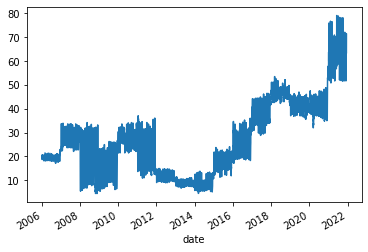

In [18]:
df['MAGN RX'].plot()

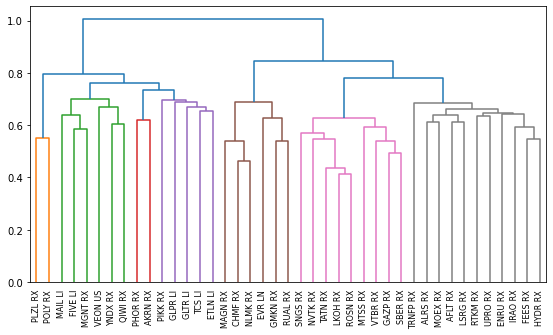

In [19]:
hrp_opt = HRPRegOpt(returns)
hrp_opt.optimize(linkage_method='ward')
hrp_opt.plot_dendrogram(show_tickers=True)

In [20]:
hrp_opt = HRPRegOpt(returns)
weights = hrp_opt.optimize(global_opt_params=('efficient_risk', 0.15), linkage_method='single', lambda_reg=0.8)
portfolio_performance(returns, weights)

{'Annual return': 29.10971052693752,
 'Annual volatility': 15.000046884329423,
 'Sharpe ratio': 1.940641302751426}

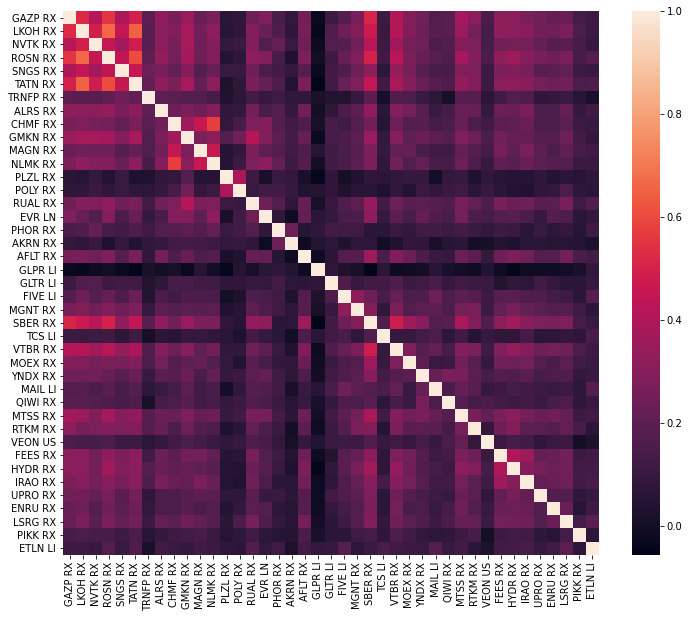

In [21]:
corr = returns.corr()

fig = plt.figure()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr,
        yticklabels=corr)

fig.set_size_inches(12, 10)
plt.savefig('corr_heat_map_origin.png')

In [22]:
matrix = np.sqrt(np.clip((1.0 - corr) / 2.0, a_min=0.0, a_max=1.0))
dist = ssd.squareform(matrix, checks=False)
        
clusters = sch.linkage(dist, method='single')
root_node = sch.to_tree(clusters, rd=False)
corr = returns[returns.columns[root_node.pre_order()]].corr()

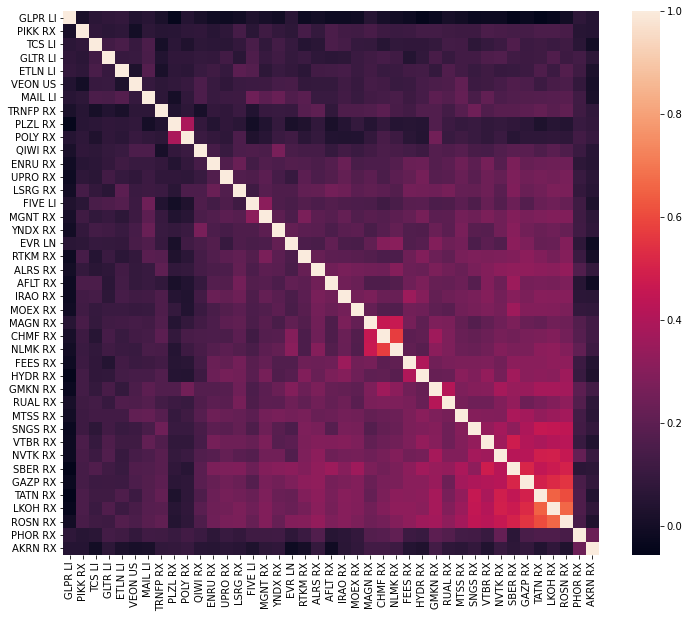

In [23]:
fig = plt.figure()

sns.heatmap(corr, 
        xticklabels=corr,
        yticklabels=corr)

fig.set_size_inches(12, 10)
plt.savefig('corr_heat_map_hrp.png')

# Evaluate out-of-sample performance and pick optimal regulariser

In [5]:
def hyper_param_opt_with_prices(hyper_param_opt_init_period,
                    hyper_param_opt_eval_period,
                    prices,
                    global_opt_params=('efficient_risk', 1.0),
                    hrp_opt_method='exact',
                    linkage_method='single',
                    risk_free_rate=0.0,
                    frequency=252,
                    num_opt_points=25):
    in_sample_metrics = {}
    out_of_sample_metrics = {}
    for lambda_reg in np.linspace(0, 1, num_opt_points):
        init_prices = df.iloc[hyper_param_opt_init_period].dropna(axis=1)
        init_returns = init_prices.pct_change().dropna()
        eval_prices = df.iloc[hyper_param_opt_eval_period].dropna(axis=1)
        eval_returns = eval_prices.pct_change().dropna()
        asset_intersect = np.intersect1d(init_returns.columns, eval_returns.columns)
        init_returns = init_returns[asset_intersect]
        eval_returns = eval_returns[asset_intersect]
        
        hrp_opt = HRPRegOpt(init_returns)
        init_weights = hrp_opt.optimize(global_opt_params=global_opt_params,
                                        hrp_opt_method=hrp_opt_method,
                                        frequency=frequency,
                                        risk_free_rate=risk_free_rate,
                                        lambda_reg=lambda_reg,
                                        linkage_method=linkage_method)
        
        in_sample_metrics[lambda_reg] = portfolio_performance(init_returns,
                                                    init_weights,
                                                    frequency=frequency,
                                                    risk_free_rate=risk_free_rate)
        
        out_of_sample_metrics[lambda_reg] = portfolio_performance(eval_returns,
                                                    init_weights,
                                                    frequency=frequency,
                                                    risk_free_rate=risk_free_rate)
    # print(asset_intersect.size)
    return (in_sample_metrics, out_of_sample_metrics)

In [6]:
np.random.seed(0)

In [41]:
df = pd.read_csv('resources/RTS_prices.csv', parse_dates=True, index_col="date")
num_days = df.shape[0]

In [42]:
n_split = 5
num_iter = 5
in_sample_metrics = []
out_of_sample_metrics = []

In [75]:
for vol in np.linspace(0.45, 0.9, 10):
    for _ in tqdm(range(num_iter)):
        init_start = np.random.choice(range(num_days - 2 * num_days // n_split), size=1)[0]
        eval_start = init_start + num_days // n_split
        sub_init_per = list(range(init_start, init_start + num_days // n_split))
        sub_eval_per = list(range(eval_start, eval_start + num_days // n_split))
    
        in_sample_metrics_iter, out_of_sample_metrics_iter = hyper_param_opt_with_prices(sub_init_per,
                                                                                         sub_eval_per,
                                                                                         df,
                                                                                         global_opt_params=('efficient_risk', vol),
                                                                                         hrp_opt_method='exact',
                                                                                         risk_free_rate=0.0,
                                                                                         frequency=252,
                                                                                         num_opt_points=25)
        in_sample_metrics.append(in_sample_metrics_iter)
        out_of_sample_metrics.append(out_of_sample_metrics_iter)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.39s/it]


In [96]:
sharpe_out_of_sample = defaultdict(list)
return_out_of_sample = defaultdict(list)
volatility_out_of_sample = defaultdict(list)

for metrics in out_of_sample_metrics:
    for lambda_reg in metrics.keys():
        sharpe_out_of_sample[lambda_reg].append(metrics[lambda_reg]['Sharpe ratio'])
        return_out_of_sample[lambda_reg].append(metrics[lambda_reg]['Annual return'])
        volatility_out_of_sample[lambda_reg].append(metrics[lambda_reg]['Annual volatility'])
        
sharpe_in_sample = defaultdict(list)
return_in_sample = defaultdict(list)
volatility_in_sample = defaultdict(list)

for metrics in in_sample_metrics:
    for lambda_reg in metrics.keys():
        sharpe_in_sample[lambda_reg].append(metrics[lambda_reg]['Sharpe ratio'])
        return_in_sample[lambda_reg].append(metrics[lambda_reg]['Annual return'])
        volatility_in_sample[lambda_reg].append(metrics[lambda_reg]['Annual volatility'])

In [126]:
avg_sharpe_out_of_sample = defaultdict(float)
avg_return_out_of_sample = defaultdict(float)
avg_volatility_out_of_sample = defaultdict(float)
avg_sharpe_in_sample = defaultdict(float)
avg_return_in_sample = defaultdict(float)
avg_volatility_in_sample = defaultdict(float)

for lambda_reg in sharpe_out_of_sample.keys():
    avg_sharpe_out_of_sample[round(lambda_reg, 2)] = np.array(sharpe_out_of_sample[lambda_reg]).mean()
    avg_sharpe_in_sample[round(lambda_reg, 2)] = np.array(sharpe_in_sample[lambda_reg]).mean()
    avg_return_out_of_sample[round(lambda_reg, 2)] = np.array(return_out_of_sample[lambda_reg]).mean()
    avg_return_in_sample[round(lambda_reg, 2)] = np.array(return_in_sample[lambda_reg]).mean()
    avg_volatility_out_of_sample[round(lambda_reg, 2)] = np.array(volatility_out_of_sample[lambda_reg]).mean()
    avg_volatility_in_sample[round(lambda_reg, 2)] = np.array(volatility_in_sample[lambda_reg]).mean()

In [106]:
avg_sharpe_out_of_sample

defaultdict(float,
            {0.0: 0.5302801783911122,
             0.04: 0.5302801783911122,
             0.08: 0.5302801783911122,
             0.12: 0.5302801783911122,
             0.17: 0.5302801783911122,
             0.21: 0.5302801783911122,
             0.25: 0.5302801783911122,
             0.29: 0.5302801783911122,
             0.33: 0.5302801783911122,
             0.38: 0.5302801783911122,
             0.42: 0.5302801783911122,
             0.46: 0.5302801783911122,
             0.5: 0.5857685103824,
             0.54: 0.532358229845084,
             0.58: 0.5051612260006224,
             0.62: 0.39464421256977994,
             0.67: 0.4347364791195591,
             0.71: 0.6494952237681669,
             0.75: 0.7462469748349513,
             0.79: 0.8124901339959076,
             0.83: 0.8500321444429696,
             0.88: 0.8360820021352332,
             0.92: 0.8420546020793495,
             0.96: 0.8420546020793495,
             1.0: 0.8420546020793495})

In [107]:
avg_sharpe_in_sample

defaultdict(float,
            {0.0: 1.1767870087985024,
             0.04: 1.1767870087985024,
             0.08: 1.1767870087985024,
             0.12: 1.1767870087985024,
             0.17: 1.1767870087985024,
             0.21: 1.1767870087985024,
             0.25: 1.1767870087985024,
             0.29: 1.1767870087985024,
             0.33: 1.1767870087985024,
             0.38: 1.1767870087985024,
             0.42: 1.1767870087985024,
             0.46: 1.1767870087985024,
             0.5: 1.187057326162651,
             0.54: 1.151507074561792,
             0.58: 1.0889164484573939,
             0.62: 1.0052540907950793,
             0.67: 0.9701341916470599,
             0.71: 0.870808354043842,
             0.75: 0.8618322613069404,
             0.79: 0.8911481382257038,
             0.83: 0.8658950211790828,
             0.88: 1.0635182432381265,
             0.92: 1.1087508401380395,
             0.96: 1.1087508401380395,
             1.0: 1.1087508401380395})

In [108]:
avg_return_out_of_sample

defaultdict(float,
            {0.0: 16.360507028111325,
             0.04: 16.360507028111325,
             0.08: 16.360507028111325,
             0.12: 16.360507028111325,
             0.17: 16.360507028111325,
             0.21: 16.360507028111325,
             0.25: 16.360507028111325,
             0.29: 16.360507028111325,
             0.33: 16.360507028111325,
             0.38: 16.360507028111325,
             0.42: 16.360507028111325,
             0.46: 16.360507028111325,
             0.5: 18.389748546436373,
             0.54: 15.447469004501345,
             0.58: 14.045143362229581,
             0.62: 11.110721110760148,
             0.67: 11.485787522759285,
             0.71: 16.240921581939702,
             0.75: 17.67158210123445,
             0.79: 18.289036405868668,
             0.83: 19.14852062144548,
             0.88: 15.054005133086367,
             0.92: 13.137432884979535,
             0.96: 13.137432884979535,
             1.0: 13.137432884979535})

In [110]:
avg_return_in_sample

defaultdict(float,
            {0.0: 47.814049086620464,
             0.04: 47.814049086620464,
             0.08: 47.814049086620464,
             0.12: 47.814049086620464,
             0.17: 47.814049086620464,
             0.21: 47.814049086620464,
             0.25: 47.814049086620464,
             0.29: 47.814049086620464,
             0.33: 47.814049086620464,
             0.38: 47.814049086620464,
             0.42: 47.814049086620464,
             0.46: 47.814049086620464,
             0.5: 47.66837973279791,
             0.54: 44.328541262468825,
             0.58: 40.49003897615958,
             0.62: 37.87291466109005,
             0.67: 35.53789852865804,
             0.71: 31.623821604658456,
             0.75: 30.44500031303362,
             0.79: 29.630615726280524,
             0.83: 28.095328999569958,
             0.88: 23.601398331889637,
             0.92: 20.833971646914346,
             0.96: 20.833971646914346,
             1.0: 20.833971646914346})

In [111]:
avg_volatility_out_of_sample

defaultdict(float,
            {0.0: 32.579068775872685,
             0.04: 32.579068775872685,
             0.08: 32.579068775872685,
             0.12: 32.579068775872685,
             0.17: 32.579068775872685,
             0.21: 32.579068775872685,
             0.25: 32.579068775872685,
             0.29: 32.579068775872685,
             0.33: 32.579068775872685,
             0.38: 32.579068775872685,
             0.42: 32.579068775872685,
             0.46: 32.579068775872685,
             0.5: 32.808594121524166,
             0.54: 30.918110928298656,
             0.58: 28.904436658080275,
             0.62: 29.410844238085392,
             0.67: 28.311640938316213,
             0.71: 26.61699993891807,
             0.75: 25.972789038775105,
             0.79: 24.83074307270631,
             0.83: 23.540208238974873,
             0.88: 19.513833832655575,
             0.92: 17.914759834444354,
             0.96: 17.914759834444354,
             1.0: 17.914759834444354})

In [112]:
avg_volatility_in_sample

defaultdict(float,
            {0.0: 41.81205077139215,
             0.04: 41.81205077139215,
             0.08: 41.81205077139215,
             0.12: 41.81205077139215,
             0.17: 41.81205077139215,
             0.21: 41.81205077139215,
             0.25: 41.81205077139215,
             0.29: 41.81205077139215,
             0.33: 41.81205077139215,
             0.38: 41.81205077139215,
             0.42: 41.81205077139215,
             0.46: 41.81205077139215,
             0.5: 41.043499161875395,
             0.54: 38.25562535457333,
             0.58: 36.49067761783179,
             0.62: 38.88375925401725,
             0.67: 37.75127484623019,
             0.71: 36.38425142071513,
             0.75: 35.50029290778258,
             0.79: 34.521158997938144,
             0.83: 31.80114059242136,
             0.88: 25.90989778475729,
             0.92: 23.947058228884377,
             0.96: 23.947058228884377,
             1.0: 23.947058228884377})

In [130]:
avg_sharpe_out_of_sample = defaultdict(float)
avg_return_out_of_sample = defaultdict(float)
avg_volatility_out_of_sample = defaultdict(float)
avg_sharpe_in_sample = defaultdict(float)
avg_return_in_sample = defaultdict(float)
avg_volatility_in_sample = defaultdict(float)

for lambda_reg in sharpe_out_of_sample.keys():
    if lambda_reg > 0.4:
        avg_sharpe_out_of_sample[round(lambda_reg, 2)] = np.array(sharpe_out_of_sample[lambda_reg]).mean()
        avg_sharpe_in_sample[round(lambda_reg, 2)] = np.array(sharpe_in_sample[lambda_reg]).mean()
        avg_return_out_of_sample[round(lambda_reg, 2)] = np.array(return_out_of_sample[lambda_reg]).mean()
        avg_return_in_sample[round(lambda_reg, 2)] = np.array(return_in_sample[lambda_reg]).mean()
        avg_volatility_out_of_sample[round(lambda_reg, 2)] = np.array(volatility_out_of_sample[lambda_reg]).mean()
        avg_volatility_in_sample[round(lambda_reg, 2)] = np.array(volatility_in_sample[lambda_reg]).mean()

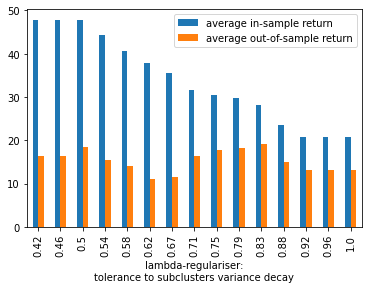

<Figure size 432x288 with 0 Axes>

In [152]:
d = {'average in-sample return': avg_return_in_sample,
     'average out-of-sample return': avg_return_out_of_sample
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser:\ntolerance to subclusters variance decay')
plt.show()
plt.draw()
fig.savefig('hrp_return_comparison.png', transparent = False, bbox_inches='tight')
fig.savefig('hrp_return_comparison.jpg', transparent = False, bbox_inches='tight')

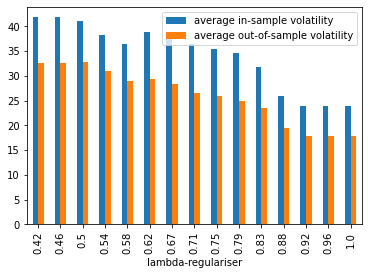

In [155]:
d = {'average in-sample volatility': avg_volatility_in_sample,
     'average out-of-sample volatility': avg_volatility_out_of_sample
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()
fig.savefig('hrp_volatility_comparison.png', transparent = False, bbox_inches='tight')
fig.savefig('hrp_volatility_comparison.jpg', transparent = False, bbox_inches='tight')

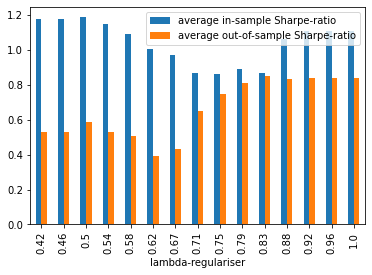

In [156]:
d = {'average in-sample Sharpe-ratio': avg_sharpe_in_sample,
     'average out-of-sample Sharpe-ratio': avg_sharpe_out_of_sample
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()
fig.savefig('hrp_sharpe_comparison.png', transparent = False, bbox_inches='tight')
fig.savefig('hrp_sharpe_comparison.jpg', transparent = False, bbox_inches='tight')

# Validation for the changing number of stocks

In [99]:
def hyper_param_opt_with_prices(hyper_param_opt_init_period,
                    hyper_param_opt_eval_period,
                    prices,
                    global_opt_params=('efficient_risk', 1.0),
                    hrp_opt_method='exact',
                    linkage_method='single',
                    risk_free_rate=0.0,
                    frequency=252,
                    num_opt_points=25):
    in_sample_metrics = {}
    out_of_sample_metrics = {}
    for lambda_reg in np.linspace(0.4, 1, num_opt_points):
        init_prices = df.iloc[hyper_param_opt_init_period].dropna(axis=1)
        init_returns = init_prices.pct_change().dropna()
        eval_prices = df.iloc[hyper_param_opt_eval_period].dropna(axis=1)
        eval_returns = eval_prices.pct_change().dropna()
        asset_intersect = np.intersect1d(init_returns.columns, eval_returns.columns)
        init_returns = init_returns[asset_intersect]
        eval_returns = eval_returns[asset_intersect]
        
        hrp_opt = HRPRegOpt(init_returns)
        init_weights = hrp_opt.optimize(global_opt_params=global_opt_params,
                                        hrp_opt_method=hrp_opt_method,
                                        frequency=frequency,
                                        risk_free_rate=risk_free_rate,
                                        lambda_reg=lambda_reg,
                                        linkage_method=linkage_method)
        
        in_sample_metrics[lambda_reg] = portfolio_performance(init_returns,
                                                    init_weights,
                                                    frequency=frequency,
                                                    risk_free_rate=risk_free_rate)
        
        out_of_sample_metrics[lambda_reg] = portfolio_performance(eval_returns,
                                                    init_weights,
                                                    frequency=frequency,
                                                    risk_free_rate=risk_free_rate)
    return (in_sample_metrics, out_of_sample_metrics)

In [100]:
def init_eval_per(n_spit, num_days):
    init_start = np.random.choice(range(num_days - 2 * num_days // n_split), size=1)[0]
    eval_start = init_start + num_days // n_split
    sub_init_per = list(range(init_start, init_start + num_days // n_split))
    sub_eval_per = list(range(eval_start, eval_start + num_days // n_split))
    return sub_init_per, sub_eval_per

In [101]:
df = pd.read_csv('resources/RTS_prices.csv', parse_dates=True, index_col="date")
df.drop('RTSI', axis=1, inplace=True)
num_days = df.shape[0]
num_days

4253

In [102]:
returns = df.pct_change().dropna()
hrp_opt = HRPRegOpt(returns)

In [103]:
num_stocks = len(df.columns)
n_split = 10
num_iter = 25
in_sample_metrics = defaultdict(list)
out_of_sample_metrics = defaultdict(list)

In [105]:
for n_stocks in tqdm(np.linspace(5, 25, 7)):
    for vol in np.linspace(0.1, 0.3, 10):
        for _ in range(num_iter):
            sub_init_per, sub_eval_per = init_eval_per(n_split, num_days)
            sub_stocks = np.random.choice(df.columns, size=int(n_stocks), replace=False)
            try:
                in_sample_metrics_iter, out_of_sample_metrics_iter = hyper_param_opt_with_prices(sub_init_per,
                                                                                                 sub_eval_per,
                                                                                                 df[sub_stocks],
                                                                                                 global_opt_params=('efficient_risk', vol),
                                                                                                 num_opt_points=20)
            except:
                pass
            in_sample_metrics[int(n_stocks)].append(in_sample_metrics_iter)
            out_of_sample_metrics[int(n_stocks)].append(out_of_sample_metrics_iter)

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [32:51<00:00, 281.63s/it]


In [106]:
sharpe_in_sample = defaultdict(lambda: defaultdict(list))
return_in_sample = defaultdict(lambda: defaultdict(list))
volatility_in_sample = defaultdict(lambda: defaultdict(list))

In [107]:
for n_stocks in in_sample_metrics:
    for metrics in in_sample_metrics[n_stocks]:
        for lambda_reg in metrics:
            sharpe_in_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Sharpe ratio'])
            return_in_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Annual return'])
            volatility_in_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Annual volatility'])

In [108]:
sharpe_out_of_sample = defaultdict(lambda: defaultdict(list))
return_out_of_sample = defaultdict(lambda: defaultdict(list))
volatility_out_of_sample = defaultdict(lambda: defaultdict(list))

In [109]:
for n_stocks in out_of_sample_metrics:
    for metrics in out_of_sample_metrics[n_stocks]:
        for lambda_reg in metrics:
            sharpe_out_of_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Sharpe ratio'])
            return_out_of_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Annual return'])
            volatility_out_of_sample[n_stocks][lambda_reg].append(metrics[lambda_reg]['Annual volatility'])

In [110]:
avg_sharpe_out_of_sample = defaultdict(lambda: defaultdict(float))
avg_return_out_of_sample = defaultdict(lambda: defaultdict(float))
avg_volatility_out_of_sample = defaultdict(lambda: defaultdict(float))
avg_sharpe_in_sample = defaultdict(lambda: defaultdict(float))
avg_return_in_sample = defaultdict(lambda: defaultdict(float))
avg_volatility_in_sample = defaultdict(lambda: defaultdict(float))

for n_stocks in sharpe_out_of_sample:
    for lambda_reg in sharpe_out_of_sample[n_stocks]:
        avg_sharpe_out_of_sample[n_stocks][round(lambda_reg, 2)] = np.array(sharpe_out_of_sample[n_stocks][lambda_reg]).mean()
        avg_sharpe_in_sample[n_stocks][round(lambda_reg, 2)] = np.array(sharpe_in_sample[n_stocks][lambda_reg]).mean()
        avg_return_out_of_sample[n_stocks][round(lambda_reg, 2)] = np.array(return_out_of_sample[n_stocks][lambda_reg]).mean()
        avg_return_in_sample[n_stocks][round(lambda_reg, 2)] = np.array(return_in_sample[n_stocks][lambda_reg]).mean()
        avg_volatility_out_of_sample[n_stocks][round(lambda_reg, 2)] = np.array(volatility_out_of_sample[n_stocks][lambda_reg]).mean()
        avg_volatility_in_sample[n_stocks][round(lambda_reg, 2)] = np.array(volatility_in_sample[n_stocks][lambda_reg]).mean()

## num_stocks: 5

In [111]:
n_stocks = 5

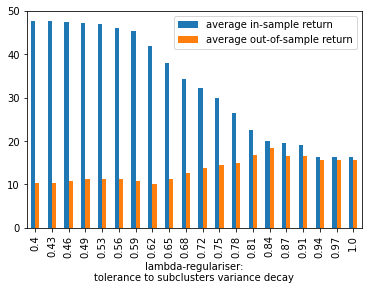

<Figure size 432x288 with 0 Axes>

In [112]:
d = {'average in-sample return': avg_return_in_sample[n_stocks],
     'average out-of-sample return': avg_return_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser:\ntolerance to subclusters variance decay')
plt.show()
plt.draw()

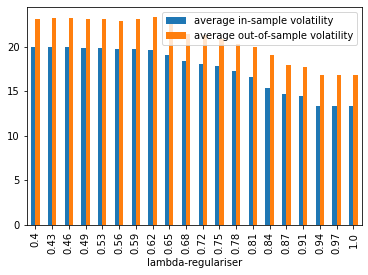

In [113]:
d = {'average in-sample volatility': avg_volatility_in_sample[n_stocks],
     'average out-of-sample volatility': avg_volatility_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()

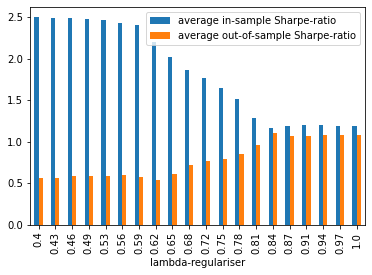

In [114]:
d = {'average in-sample Sharpe-ratio': avg_sharpe_in_sample[n_stocks],
     'average out-of-sample Sharpe-ratio': avg_sharpe_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()

## num_stocks: 15

In [119]:
n_stocks = 15

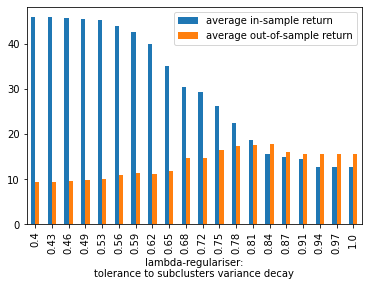

<Figure size 432x288 with 0 Axes>

In [120]:
d = {'average in-sample return': avg_return_in_sample[n_stocks],
     'average out-of-sample return': avg_return_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser:\ntolerance to subclusters variance decay')
plt.show()
plt.draw()

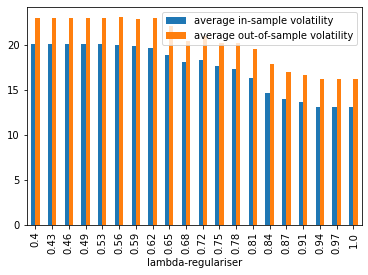

In [121]:
d = {'average in-sample volatility': avg_volatility_in_sample[n_stocks],
     'average out-of-sample volatility': avg_volatility_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()

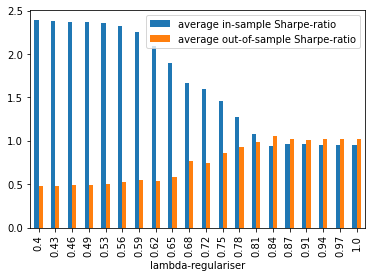

In [122]:
d = {'average in-sample Sharpe-ratio': avg_sharpe_in_sample[n_stocks],
     'average out-of-sample Sharpe-ratio': avg_sharpe_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()

## num_stocks: 25

In [127]:
n_stocks = 25

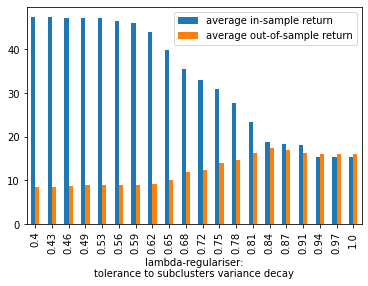

<Figure size 432x288 with 0 Axes>

In [128]:
d = {'average in-sample return': avg_return_in_sample[n_stocks],
     'average out-of-sample return': avg_return_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser:\ntolerance to subclusters variance decay')
plt.show()
plt.draw()

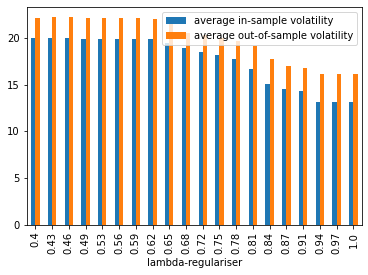

In [129]:
d = {'average in-sample volatility': avg_volatility_in_sample[n_stocks],
     'average out-of-sample volatility': avg_volatility_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()

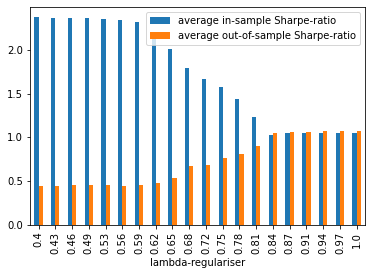

In [130]:
d = {'average in-sample Sharpe-ratio': avg_sharpe_in_sample[n_stocks],
     'average out-of-sample Sharpe-ratio': avg_sharpe_out_of_sample[n_stocks]
    }

pd.DataFrame(d).plot(kind='bar')
fig = plt.gcf()
plt.xlabel('lambda-regulariser')
plt.show()